In [1]:
# import modules
import uproot, sys, time, random, argparse, copy
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import awkward as ak
from tqdm import tqdm
import seaborn as sns
from matplotlib.ticker import FormatStrFormatter
import matplotlib.ticker as ticker
from collections import Counter
from scipy.stats import norm
from math import *

# import trackingError function
from trackingerror import Detector, inputfromfile

# Set up plot defaults
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = 14.0,10.0  # Roughly 11 cm wde by 8 cm high
mpl.rcParams['font.size'] = 20.0 # Use 14 point font
sns.set(style="whitegrid")

font_size = {
    "xlabel": 17,
    "ylabel": 17,
    "xticks": 15,
    "yticks": 15,
    "legend": 13,
    "title": 13,
}

plt.rcParams.update({
    "axes.labelsize": font_size["xlabel"],  # X and Y axis labels
    "xtick.labelsize": font_size["xticks"],  # X ticks
    "ytick.labelsize": font_size["yticks"],  # Y ticks
    "legend.fontsize": font_size["legend"]  # Legend
})

### Look at one pT value

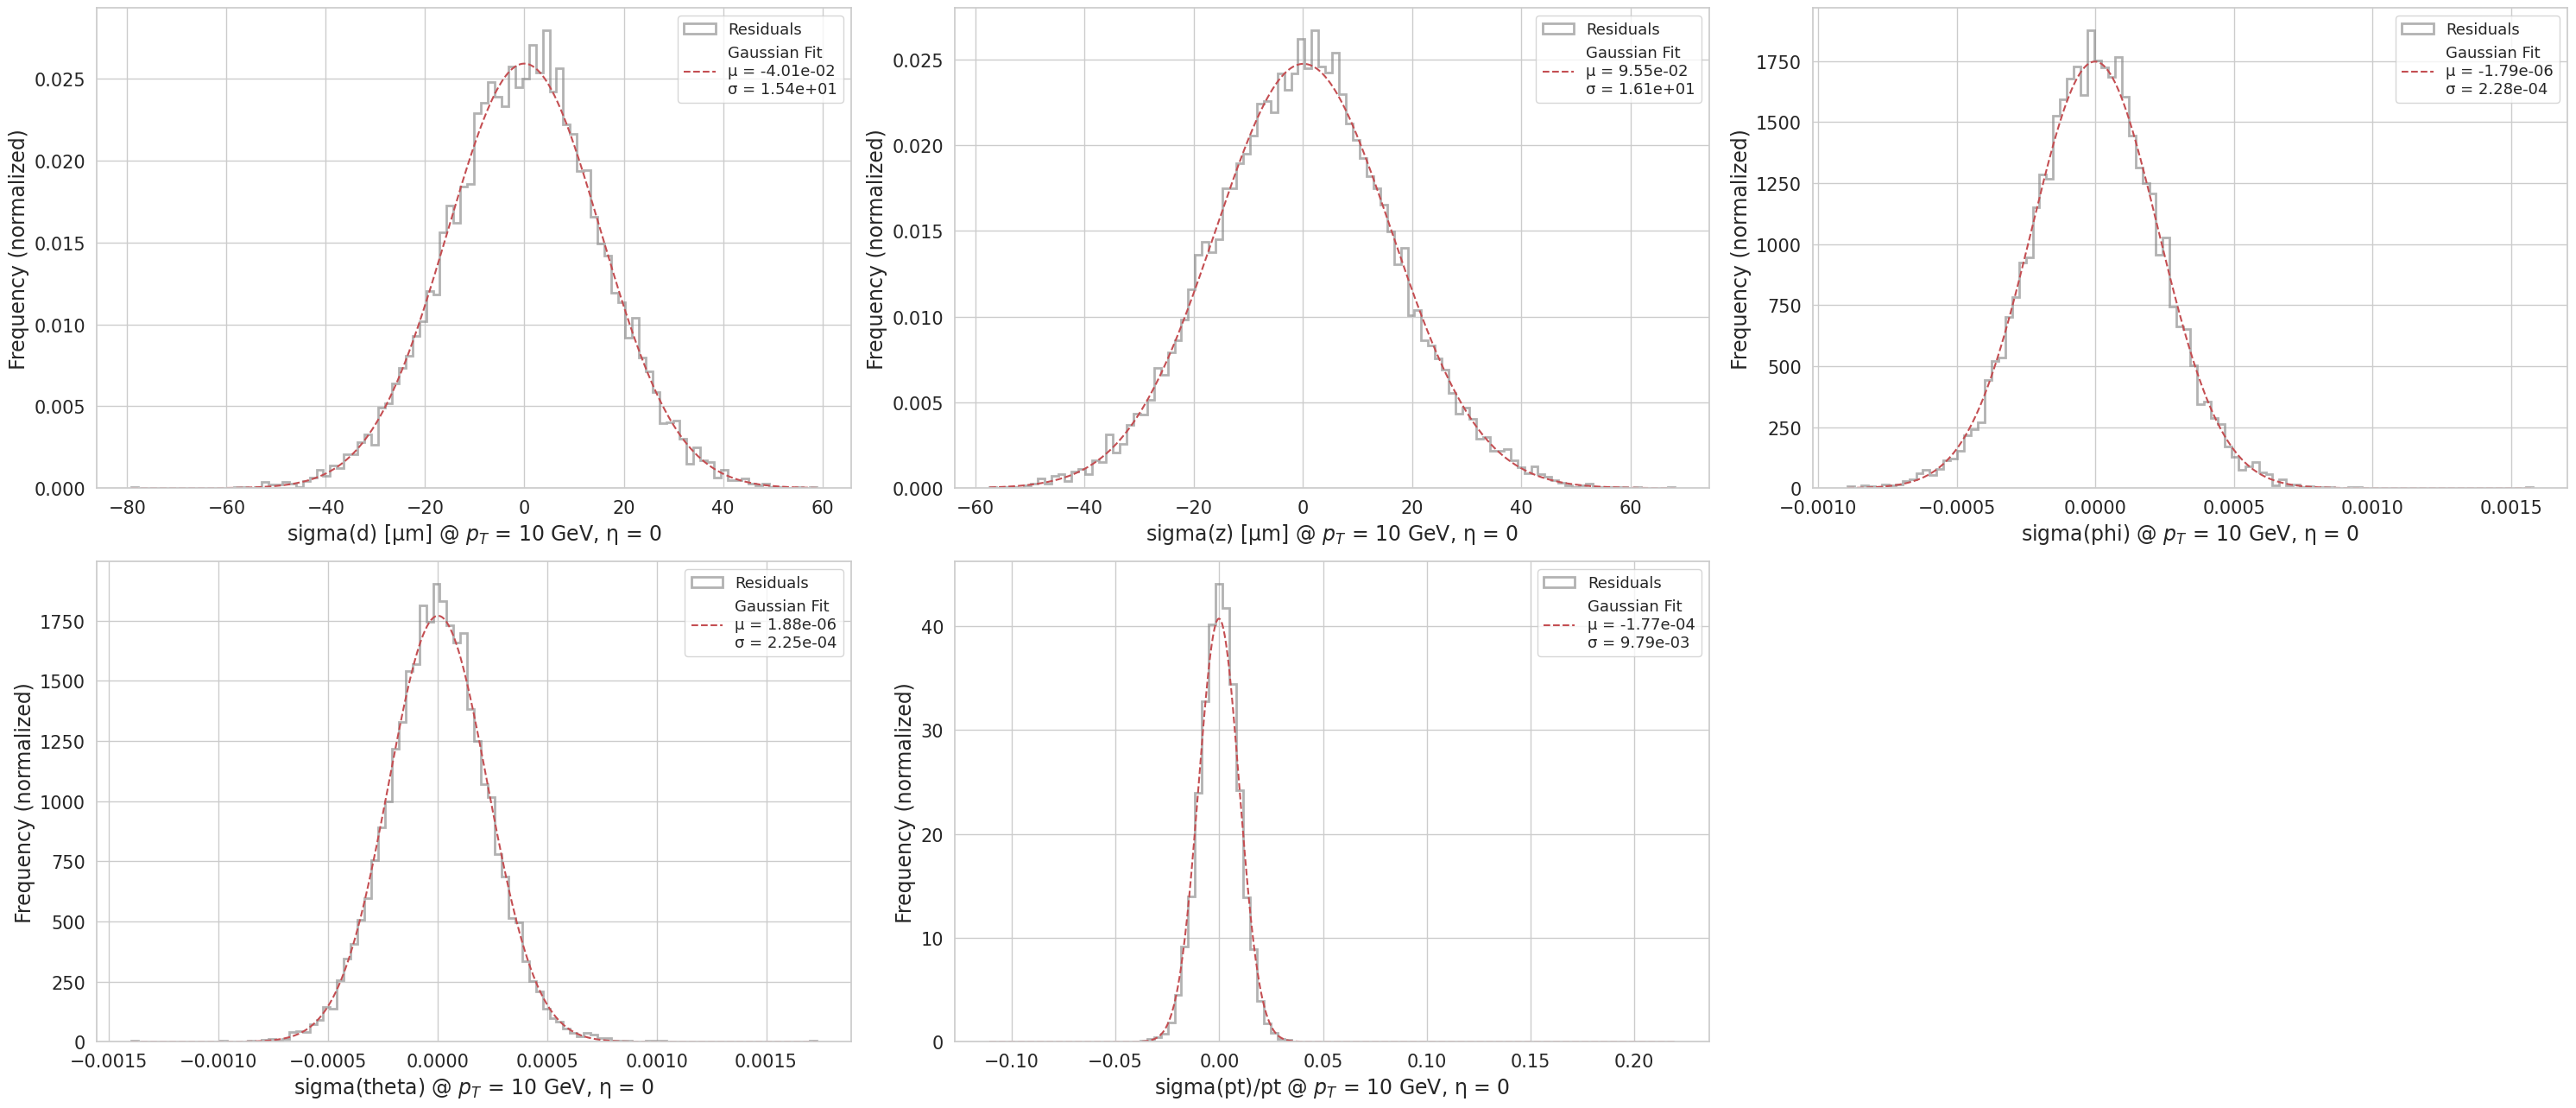

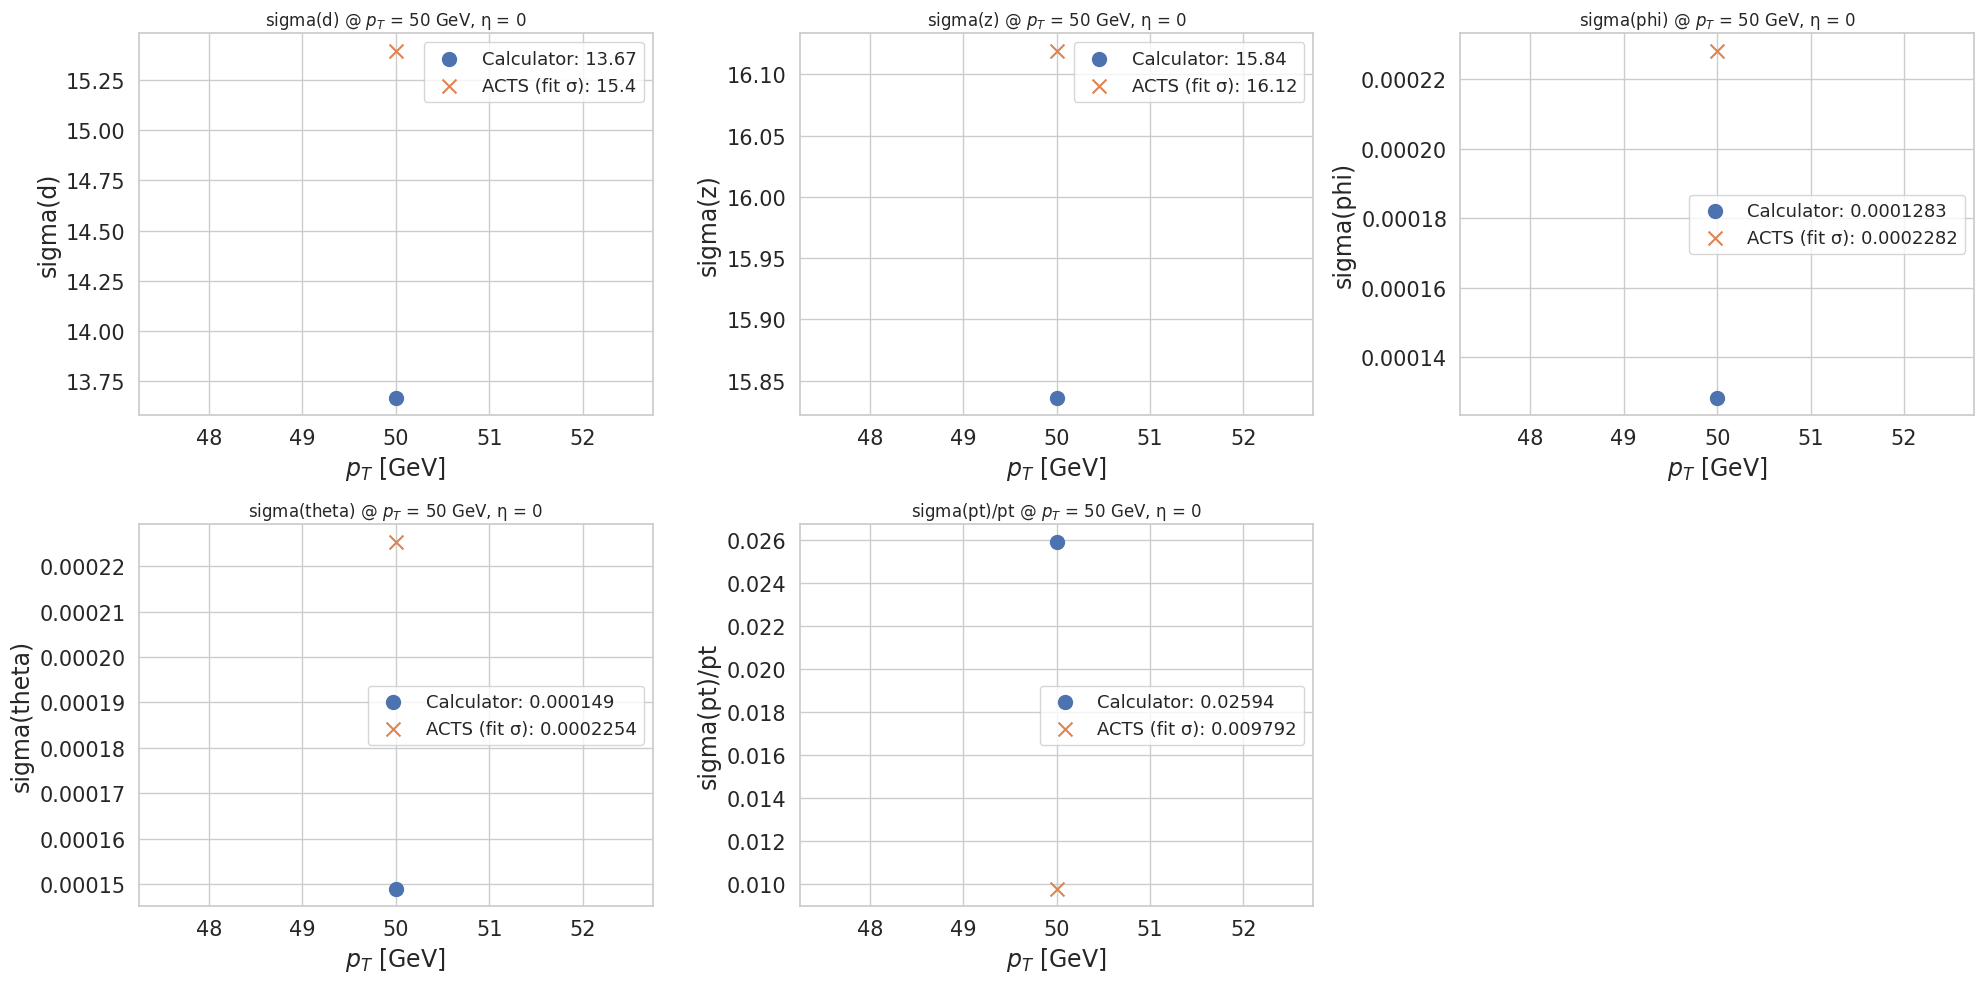

In [8]:
path = '/data/jlai/iris-hep/res_pT2/'
# pT_values = [1, 3, 5, 10]
pT_values = np.arange(10, 100, 10)
i = 0
file = uproot.open(path + f'output_pt_{pT_values[i]}' + '/tracksummary_ckf.root')
# file = uproot.open("/data/jlai/iris-hep/output_100000/tracksummary_ckf.root")

tree = file['tracksummary']

# < -- Fitting with no plot -- >
arrays = tree.arrays(["t_d0", "eLOC0_fit", "res_eLOC0_fit", "pull_eLOC0_fit",
                      "t_z0", "eLOC1_fit", "res_eLOC1_fit", "pull_eLOC1_fit",
                      "t_phi", "ePHI_fit", "res_ePHI_fit", "pull_ePHI_fit",
                      "t_theta", "eTHETA_fit", "res_eTHETA_fit", "pull_eTHETA_fit",
                      "t_p", "eQOP_fit", "res_ePT_fit", "res_ePTrel_fit",
                      "t_charge"], library='ak')

pT_truth = arrays['t_p'] * np.sin(arrays['t_theta'])
pT_reco = np.abs( 1 / arrays['eQOP_fit'] ) * np.sin(arrays['eTHETA_fit'])

labels = {
    'sigma(d)': ak.flatten(arrays['res_eLOC0_fit']) * 1e3, # converting from unit mm to unit um
    'sigma(z)': ak.flatten(arrays['res_eLOC1_fit']) * 1e3, # converting to unit um
    'sigma(phi)': ak.flatten(arrays['res_ePHI_fit']),
    'sigma(theta)': ak.flatten(arrays['res_eTHETA_fit']),
    'sigma(pt)/pt': ak.flatten(arrays['res_ePT_fit']/pT_reco),
}

'''
fit_results = {}
plt.figure(figsize=(30, 13))
title_labels = ['sigma(d) [μm]', 'sigma(z) [μm]', 'sigma(phi)', 'sigma(theta)', 'sigma(pt)/pt']
for key, data in labels.items():
    data = ak.to_numpy(data)
    data = data[~np.isnan(data)]

    mu, sigma = norm.fit(data)
    fit_results[key] = sigma
    
    plt.subplot(231 + list(fit_results.keys()).index(key))
    counts, bins, _ = plt.hist(data, bins=100, histtype='step', linewidth=2, density=True, alpha=0.6, color='gray', label='Residuals')

    x = np.linspace(bins[0], bins[-1], 1000)
    plt.plot(x, norm.pdf(x, mu, sigma), 'r--', label=f'pT={pT_values[i]} Gaussian Fit\nμ = {mu:.2e}\nσ = {sigma:.2e}')

    plt.title(f"{title_labels} @ $p_T$ = {p} GeV, η = {eta}")
    plt.xlabel(key)
    plt.ylabel("Frequency (normlized)")
    plt.legend()
    plt.grid(True)
'''
p, eta = pT_values[i], 0
B, m = 2, 0.106
fit_results = {}

# Decide the order explicitly so plots are stable
keys_order = ['sigma(d)', 'sigma(z)', 'sigma(phi)', 'sigma(theta)', 'sigma(pt)/pt']
title_labels = ['sigma(d) [μm]', 'sigma(z) [μm]', 'sigma(phi)', 'sigma(theta)', 'sigma(pt)/pt']

plt.figure(figsize=(30, 13))

for i, key in enumerate(keys_order):
    data = ak.to_numpy(labels[key])
    data = data[~np.isnan(data)]

    if data.size == 0:
        fit_results[key] = np.nan
        continue

    mu, sigma = norm.fit(data)
    fit_results[key] = sigma

    plt.subplot(2, 3, i + 1)
    counts, bins, _ = plt.hist(data, bins=100, histtype='step', linewidth=2,
                               density=True, alpha=0.6, color='gray', label='Residuals')

    x = np.linspace(bins[0], bins[-1], 1000)
    plt.plot(x, norm.pdf(x, mu, sigma),
             'r--', label=f'Gaussian Fit\nμ = {mu:.2e}\nσ = {sigma:.2e}')

    plt.xlabel(f"{title_labels[i]} @ $p_T$ = {p} GeV, η = {eta}")
    # plt.xlabel(key)
    plt.ylabel("Frequency (normalized)")
    plt.legend()
    plt.grid(True)

plt.tight_layout()
plt.savefig(f'/data/jlai/iris-hep-log/TrackingResolution-3.0/TrackingResolution-3.0/plots/fitted_gaussian_pT{pT_values[i]}.png')

# < -- Tracking Error Calculator -- >
p, eta = pT_values[i], 0
B, m = 2, 0.106
path = '/data/jlai/iris-hep-log/TrackingResolution-3.0/TrackingResolution-3.0/'
mydetector = inputfromfile(path+'ODD.txt', 0)
calc_result = mydetector.errorcalculation(p, B, eta, m)

# < -- plot comparsion -- >
var_labels = ['sigma(d)', 'sigma(z)', 'sigma(phi)', 'sigma(theta)', 'sigma(pt)/pt']

plt.figure(figsize=(20, 10))
for var_label in var_labels:
    idx = var_labels.index(var_label)
    plt.subplot(231 + idx)

    key = var_label
    y_calc = calc_result[var_label]
    y_acts = fit_results[key]

    plt.scatter(p, y_calc, marker='o', s=100, label=f"Calculator: {y_calc:.4g}")
    plt.scatter(p, y_acts, marker='x', s=100, label=f"ACTS (fit σ): {y_acts:.4g}")
    plt.xlabel(r"$p_T$ [GeV]")
    plt.ylabel(var_label)
    plt.title(f"{var_label} @ $p_T$ = {p} GeV, η = {eta}")
    plt.legend()
    plt.grid(True)

plt.tight_layout()
plt.show()

### Saving ACTS results

In [27]:
path = '/data/jlai/iris-hep/OutputPT/'
var_labels = ['sigma(d)', 'sigma(z)', 'sigma(phi)', 'sigma(theta)', 'sigma(pt)/pt']

y_acts = {label: [] for label in var_labels}
y_acts_err = {label: [] for label in var_labels}

pT_values = np.concatenate((np.linspace(1, 15, 15), np.linspace(20, 100, 9)))
# pT_values = np.arange(10, 100, 10)
for pT_value in pT_values:
    pT_value = int(pT_value)
    print(f'Saving ACTS track resol with pT = {pT_value} GeV')
    file = uproot.open(path + f'output_pt_{pT_value}' + '/tracksummary_ckf.root')
    tree = file['tracksummary']

    # < -- Fitting with no plot -- >
    arrays = tree.arrays(["t_d0", "eLOC0_fit", "res_eLOC0_fit",
                        "t_z0", "eLOC1_fit", "res_eLOC1_fit",
                        "t_phi", "ePHI_fit", "res_ePHI_fit",
                        "t_theta", "eTHETA_fit", "res_eTHETA_fit",
                        "t_p", "t_pT", "eQOP_fit", "res_eQOP_fit",
                        "t_charge"], library='ak')

    pT_truth = arrays['t_p'] * np.sin(arrays['t_theta'])
    pT_reco = np.abs( 1 / arrays['eQOP_fit'] ) * np.sin(arrays['t_theta'])
    # pT_reco = np.abs( 1 / arrays['eQOP_fit'] ) * np.sin(arrays['eTHETA_fit'])

    labels = {
        'sigma(d)': ak.flatten(arrays['res_eLOC0_fit']) * 1e3, # converting from unit mm to unit um
        'sigma(z)': ak.flatten(arrays['res_eLOC1_fit']) * 1e3, # converting to unit um
        'sigma(phi)': ak.flatten(arrays['res_ePHI_fit']),
        'sigma(theta)': ak.flatten(arrays['res_eTHETA_fit']),
        'sigma(pt)/pt': ak.flatten((pT_reco - pT_truth)/pT_reco)
    }

    plt.figure(figsize=(30, 13))
    for key, data in labels.items():
        data = ak.to_numpy(data)
        data = data[~np.isnan(data)]

        N = len(data)
        mu, sigma = norm.fit(data)

        y_acts[key].append(sigma)
        # y_acts_err[key].append(sigma / np.sqrt(2 * N) if N > 0 else 0)
        y_acts_err[key].append(sigma / np.sqrt(2*max(N-1,1)) if N > 1 else 0.0)

Saving ACTS track resol with pT = 1 GeV
Saving ACTS track resol with pT = 2 GeV
Saving ACTS track resol with pT = 3 GeV
Saving ACTS track resol with pT = 4 GeV
Saving ACTS track resol with pT = 5 GeV
Saving ACTS track resol with pT = 6 GeV
Saving ACTS track resol with pT = 7 GeV
Saving ACTS track resol with pT = 8 GeV
Saving ACTS track resol with pT = 9 GeV
Saving ACTS track resol with pT = 10 GeV
Saving ACTS track resol with pT = 11 GeV
Saving ACTS track resol with pT = 12 GeV
Saving ACTS track resol with pT = 13 GeV
Saving ACTS track resol with pT = 14 GeV
Saving ACTS track resol with pT = 15 GeV
Saving ACTS track resol with pT = 20 GeV
Saving ACTS track resol with pT = 30 GeV
Saving ACTS track resol with pT = 40 GeV
Saving ACTS track resol with pT = 50 GeV
Saving ACTS track resol with pT = 60 GeV
Saving ACTS track resol with pT = 70 GeV


/tmp/ipykernel_3475362/3025510716.py:35: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure(figsize=(30, 13))


Saving ACTS track resol with pT = 80 GeV
Saving ACTS track resol with pT = 90 GeV
Saving ACTS track resol with pT = 100 GeV


<Figure size 3000x1300 with 0 Axes>

<Figure size 3000x1300 with 0 Axes>

<Figure size 3000x1300 with 0 Axes>

<Figure size 3000x1300 with 0 Axes>

<Figure size 3000x1300 with 0 Axes>

<Figure size 3000x1300 with 0 Axes>

<Figure size 3000x1300 with 0 Axes>

<Figure size 3000x1300 with 0 Axes>

<Figure size 3000x1300 with 0 Axes>

<Figure size 3000x1300 with 0 Axes>

<Figure size 3000x1300 with 0 Axes>

<Figure size 3000x1300 with 0 Axes>

<Figure size 3000x1300 with 0 Axes>

<Figure size 3000x1300 with 0 Axes>

<Figure size 3000x1300 with 0 Axes>

<Figure size 3000x1300 with 0 Axes>

<Figure size 3000x1300 with 0 Axes>

<Figure size 3000x1300 with 0 Axes>

<Figure size 3000x1300 with 0 Axes>

<Figure size 3000x1300 with 0 Axes>

<Figure size 3000x1300 with 0 Axes>

<Figure size 3000x1300 with 0 Axes>

<Figure size 3000x1300 with 0 Axes>

<Figure size 3000x1300 with 0 Axes>

### Comparison between ACTS and Tracking Resolution Calculator

Layers added (x/X0, sigma_xy [m], sigma_z [m or 9999], R [m]):
 volume_id  layer_id   tech  x_over_X0  sigma_loc0_m  sigma_loc1_m      R_m
        17         2  pixel   0.012278      0.000015      0.000015 0.032213
        17         4  pixel   0.012278      0.000015      0.000015 0.068195
        17         6  pixel   0.012278      0.000015      0.000015 0.114204
        17         8  pixel   0.012278      0.000015      0.000015 0.170208
        24         2 sstrip   0.018912      0.000043      0.001200 0.259940
        24         4 sstrip   0.018912      0.000043      0.001200 0.359965
        24         6 sstrip   0.018912      0.000043      0.001200 0.499994
        24         8 sstrip   0.018912      0.000043      0.001200 0.659979
        29         2 lstrip   0.030750      0.000072   9999.000000 0.820230
        29         4 lstrip   0.030750      0.000072   9999.000000 1.020167
Layers added (x/X0, sigma_xy [m], sigma_z [m or 9999], R [m]):
 volume_id  layer_id   tech  x_over_X0

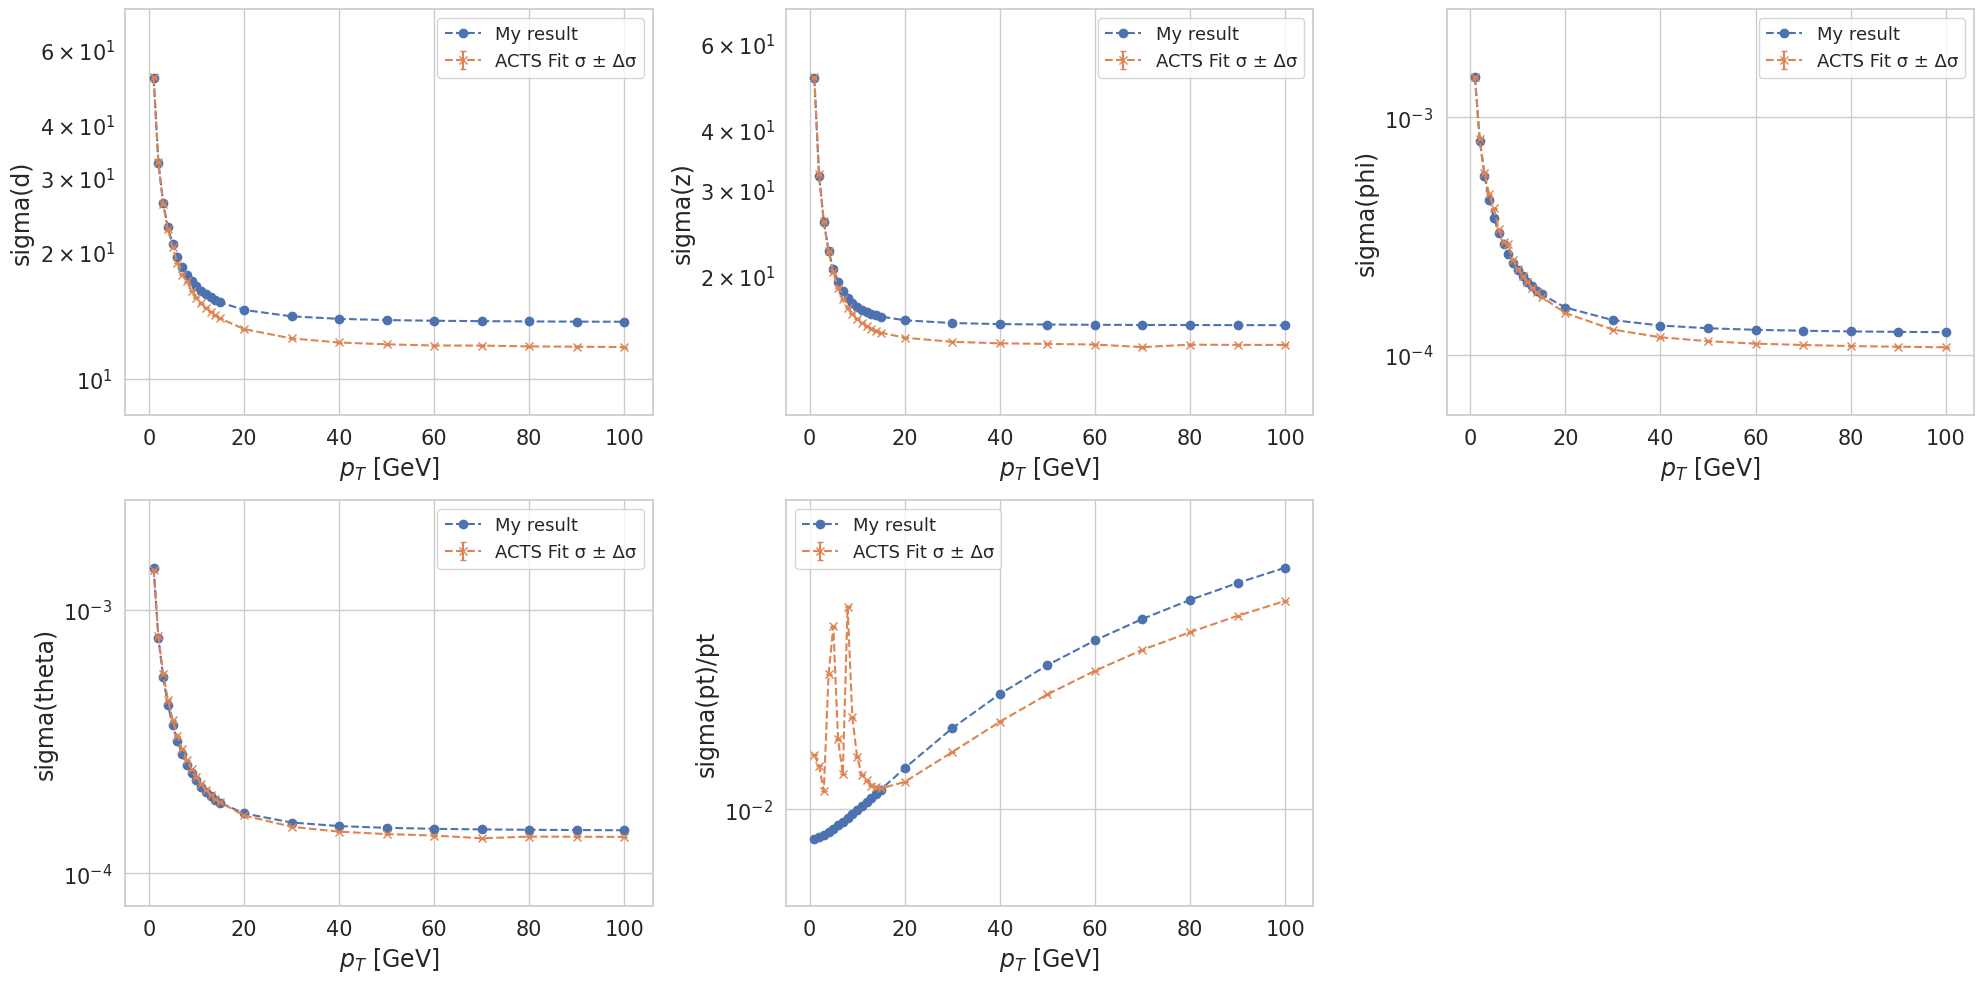

In [40]:
def D(pT_value, eta_value):    
    MEAS_PATH = f"/data/jlai/iris-hep/OutputPT/output_pt_{pT_value}/measurements.root"
    MAT_PATH  = "/data/jlai/iris-hep/material_composition.root"

    PIXEL   = {16, 17, 18}   # 17 barrel, 16/18 endcaps
    SSTRIP  = {23, 24, 25}
    LSTRIP  = {28, 29, 30}

    def vol_to_tech(vid: int) -> str:
        if vid in PIXEL:  return "pixel"
        if vid in SSTRIP: return "sstrip"
        if vid in LSTRIP: return "lstrip"
        return "pixel"  # fallback

    # ---------- per-layer medians from measurements ----------
    cols = ["volume_id","layer_id","true_x","true_y","true_z","var_loc0","var_loc1","residual_loc0","residual_loc1"]
    with uproot.open(MEAS_PATH) as f:
        a = f["measurements"].arrays(cols, library="pd")

    a["R_m"]           = np.sqrt(a.true_x**2 + a.true_y**2) * 1e-3
    a["sigma_loc0_m"]  = np.sqrt(a.var_loc0.clip(lower=0)) * 1e-3
    a["sigma_loc1_m"]  = np.sqrt(a.var_loc1.clip(lower=0)) * 1e-3

    def _std_meters(s):
        return np.nanstd(s, ddof=0) * 1e-3

    df_layers = (
        a.groupby(["volume_id","layer_id"], as_index=False)
        .agg(R_m=("R_m","median"),
            sigma_loc0_m=("sigma_loc0_m","median"),
            sigma_loc1_m=("sigma_loc1_m","median"))
            # sigma_loc0_m=("residual_loc0", _std_meters),
            # sigma_loc1_m=("residual_loc0", _std_meters))
        .sort_values(["volume_id","layer_id"])
        .reset_index(drop=True)
    )

    # ---------- x/X0 per technology at η≈eta_value ----------
    with uproot.open(MAT_PATH) as mf:
        def x0_at_eta0(key):
            h = mf[key]
            edges = h.axis().edges() if hasattr(h, "axis") else np.linspace(-5,5,len(h.values())+1)
            vals  = h.values()
            i = int(np.clip(np.digitize([eta_value], edges)[0] - 1, 0, len(vals)-1))
            return float(vals[i])
        x0_beam  = x0_at_eta0("beampipe_x0_vs_eta_all")
        x0_pixel = x0_at_eta0("pixel_x0_vs_eta_all")
        x0_sstr  = x0_at_eta0("sstrips_x0_vs_eta_all")
        x0_lstr  = x0_at_eta0("lstrips_x0_vs_eta_all")

    def x0_for_tech(tech: str) -> float:
        return {"pixel": x0_pixel, "sstrip": x0_sstr, "lstrip": x0_lstr}.get(tech, x0_pixel)

    df_layers["tech"]       = df_layers["volume_id"].map(vol_to_tech)
        
    x0_map = {
        "pixel":  x0_pixel,
        "sstrip": x0_sstr,
        "lstrip": x0_lstr,
    }
    df_layers["x0_total_by_tech"] = df_layers["tech"].map(x0_map)

    n_layers_by_tech = df_layers.groupby("tech").size().to_dict() # count layers per tech

    # Per-layer share: total / count
    df_layers["x_over_X0"] = df_layers.apply(
        lambda r: r["x0_total_by_tech"] / max(n_layers_by_tech.get(r["tech"], 1), 1),
        axis=1,
    )

    # df_layers["x_over_X0"]  = df_layers["tech"].map(x0_for_tech)

    df_layers["sigma_loc1_for_add"] = df_layers["sigma_loc1_m"].fillna(9999.0) # fill NaN with 9999

    # ---------- build Detector ----------
    mydetector = Detector()

    mydetector.addlayer(x0_beam, 9999.0, 9999.0, 0.024)

    for _, row in df_layers.sort_values("R_m").iterrows():
        mydetector.addlayer(
            float(row["x_over_X0"]),
            float(row["sigma_loc0_m"]),
            float(row["sigma_loc1_for_add"]),  # <- NaNs become 9999 here
            float(row["R_m"]),
        )

    # ---------- print (optional) ----------
    out = df_layers.copy()
    out["sigma_loc1_m"] = out["sigma_loc1_m"].fillna(9999.0)
    print("Layers added (x/X0, sigma_xy [m], sigma_z [m or 9999], R [m]):")
    print(out[["volume_id","layer_id","tech","x_over_X0","sigma_loc0_m","sigma_loc1_m","R_m"]]
          .to_string(index=False))
    return mydetector


# < -- Tracking Error Calculator -- >
def cal2():
    y_calc = {label: [] for label in var_labels}

    for pT_value in pT_values:
        pT_value = int(pT_value)
        p, eta = pT_value, 0
        B, m = 2.0, 0.105658
        mydetector = D(p, eta)
        calc_result = mydetector.errorcalculation(p, B, eta, m)

        for var_label in var_labels:
            y_calc[var_label].append(calc_result[var_label])
    return y_calc

path = '/data/jlai/iris-hep-log/TrackingResolution-3.0/TrackingResolution-3.0/'
y_calc_result = cal2()

# < -- plot the var vs. pT -- >
plt.figure(figsize=(20, 10))
for var_label in var_labels:
    idx = var_labels.index(var_label)
    plt.subplot(231 + idx)

    # plt.plot(pT_values, y_calc_default[var_label], 'o--', label=f"Default Calculator in zenodo")
    plt.plot(pT_values, y_calc_result[var_label], 'o--', label=f"My result")

    # plt.plot(pT_values, y_acts[var_label], 'x--', label=f"ACTS (fit σ)")
    plt.errorbar(pT_values, y_acts[var_label], yerr=y_acts_err[var_label], fmt='x--', capsize=2, label="ACTS Fit σ ± Δσ")
    plt.xlabel(r"$p_T$ [GeV]")
    plt.ylabel(var_label)
    # plt.title(f"{var_label} @ $p_T$ = {p} GeV, η = {eta}")
    plt.yscale('log')
    plt.legend()
    plt.grid(True)
    plt.margins(x=0.06, y=0.25)  # increase y if you want even more headroom

plt.tight_layout()
plt.show()

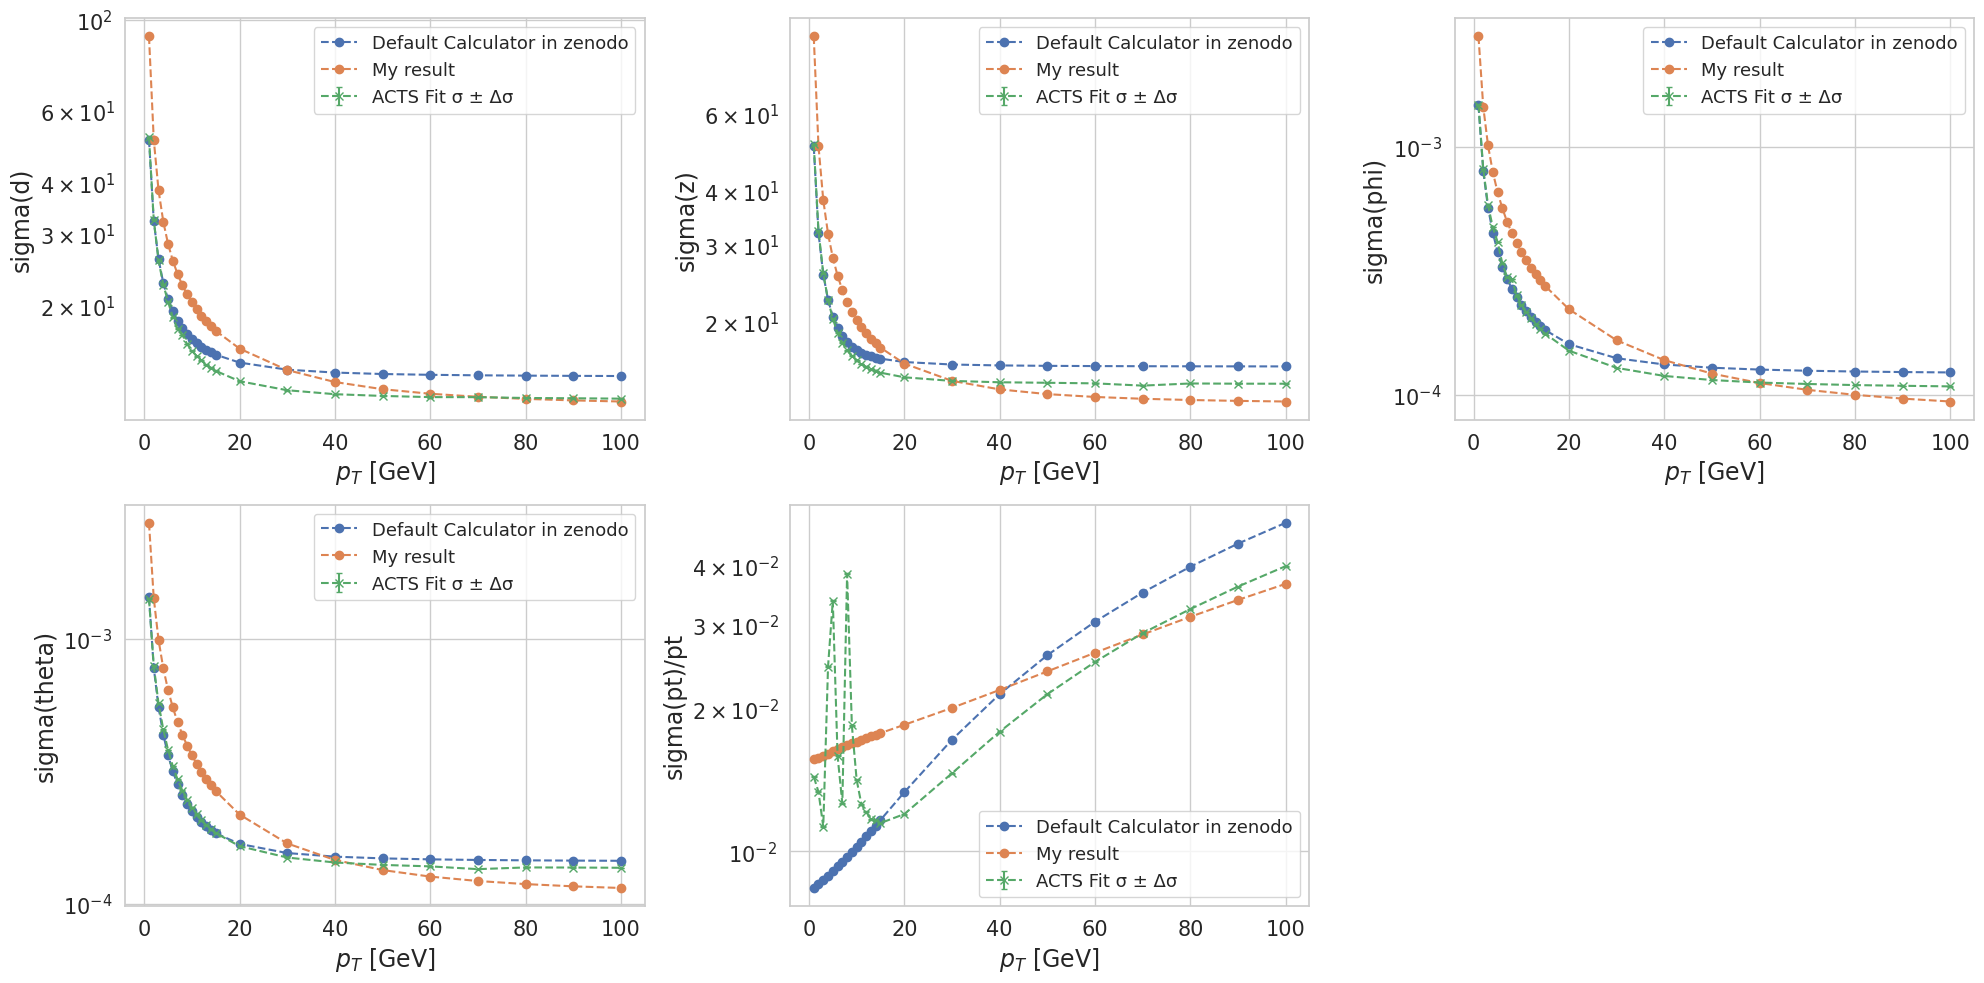

In [34]:
# < -- Tracking Error Calculator -- >
def cal(inputfile='ODD.txt'):
    y_calc = {label: [] for label in var_labels}

    for pT_value in pT_values:
        pT_value = int(pT_value)
        p, eta = pT_value, 0
        B, m = 2.0, 0.105658
        mydetector = inputfromfile(inputfile, 0)
        calc_result = mydetector.errorcalculation(p, B, eta, m)

        for var_label in var_labels:
            y_calc[var_label].append(calc_result[var_label])
    return y_calc

path = '/data/jlai/iris-hep-log/TrackingResolution-3.0/TrackingResolution-3.0/'
y_calc_default = cal(path+'ODD.txt')
y_calc_result = cal(path+'myODD_test.txt')

# < -- plot the var vs. pT -- >
plt.figure(figsize=(20, 10))
for var_label in var_labels:
    idx = var_labels.index(var_label)
    plt.subplot(231 + idx)

    plt.plot(pT_values, y_calc_default[var_label], 'o--', label=f"Default Calculator in zenodo")
    plt.plot(pT_values, y_calc_result[var_label], 'o--', label=f"My result")

    # plt.plot(pT_values, y_acts[var_label], 'x--', label=f"ACTS (fit σ)")
    plt.errorbar(pT_values, y_acts[var_label], yerr=y_acts_err[var_label], fmt='x--', capsize=2, label="ACTS Fit σ ± Δσ")
    plt.xlabel(r"$p_T$ [GeV]")
    plt.ylabel(var_label)
    # plt.title(f"{var_label} @ $p_T$ = {p} GeV, η = {eta}")
    plt.yscale('log')
    plt.legend()
    plt.grid(True)

plt.tight_layout()
plt.show()
